In [ ]:
import numpy as np
import os
import math

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils import data

import scipy.io
import pickle
from matplotlib import cm
import matplotlib.pyplot as plt

In [ ]:
cuda = torch.cuda.is_available()
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
torch.set_default_dtype(torch.float)
batch_size = 64
print(torch.cuda.device_count(),torch.cuda.get_device_properties(0), cuda, device)
default_type = torch.get_default_dtype()

In [ ]:
class FWIdataset(Dataset):
    """FWI dataset."""

    def __init__(self, dataset_path, file_name, data_index, device = 'cpu', \
                 transform=None, target_transform=None):
        """
        Args:
            dataset_path (string): Path to FWI data set.
            file_name (string): pre file name of each data point.
            data_index (list -> int) index for data points
            transform (callable, optional): Optional transform to be applied
                on a sample.
            target_transform (callable, optional): Optional transform to be applied
                on a y_exact.
            device (cuda or cpu): Device to do computation
        """
        
        self.dataset_path = dataset_path
        self.file_name = file_name
        self.data_index = np.array(data_index)
        self.transform = transform
        self.target_transform = target_transform
        self.device = device
        
    def __len__(self):
        return len(self.data_index)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        #print(self.kinship_labels.iloc[idx, 0])
        datapoint_path = os.path.join(self.dataset_path, self.file_name +
                                str(self.data_index[idx])+".mat")
        data = scipy.io.loadmat(datapoint_path)
        y_exact = data['y_temp']
        sample = data['sample_temp']
        #print(y_exact.dtype)
        
        
        if self.transform:
            #print(image.shape)
            sample = self.transform(sample)
        #image = torch.cat((image1,image2), dim=0)
        if self.target_transform:
            y_exact = self.target_transform(y_exact)
        #print(sample.shape)
        return torch.tensor(sample).to(device), \
               torch.tensor(y_exact).to(device)
    
    
#transform = transforms.Compose([ transforms.ToTensor(),])
#target_transform = transforms.Compose([ transforms.ToTensor(),])

In [ ]:
train_path = "/burg/apam/users/wd2288/FWI/dataset/8fourier_3channel_notdecay"
file_name = ""
train_data_index = np.arange(32950)
#train_data_index = np.concatenate((np.arange(13500), np.arange(15000,18500)))
#train_data_index = np.array(list(range(1700)) + list(range(2000,3700)))
train_data = FWIdataset(train_path, file_name, train_data_index, device)
train_loader = DataLoader(train_data, batch_size=6, shuffle=True)

In [5]:
test_path = "/burg/apam/users/wd2288/FWI/dataset/8fourier_3channel_notdecay"
file_name = ""
test_data_index = np.arange(32950,33000)
test_data = FWIdataset(test_path, file_name, test_data_index, device)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

tensor(0.0717, device='cuda:0')


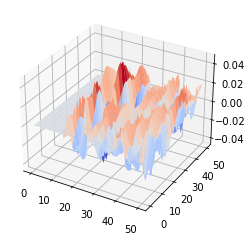

In [6]:
datair = iter(test_loader)
sample, y_exact = datair.next()
#print(sample.permute((1,0,2,3)).shape, y_exact.shape)
#print(sample[0].shape, y_exact[0].shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = np.arange(51)
Y = np.arange(51)
X, Y = np.meshgrid(X, Y)
z = sample[0][2][0].cpu().numpy().reshape(51,51)

print(torch.max(sample))
# Plot the surface.
surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm)

/burg/home/wd2288/.local/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


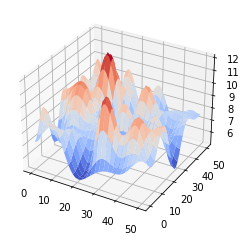

In [7]:
Nx = 50
hx = 1/Nx
Ny = 50
hy = 1/Ny
dt = 0.0005
T = 1000*dt
Nsteps = int(T/dt)

num_modes = 8

xc = torch.arange(0,1+hx,hx, device = device)
yc = torch.arange(-1,hy,hy, device = device)
#yc = torch.arange(-1,hy,hy, device = device)
grid_y, grid_x = torch.meshgrid(yc, xc)
pi = torch.tensor(math.pi)


xc = torch.arange(0,num_modes, device = device)
yc = torch.arange(0,num_modes, device = device)
x_mode_mat, y_mode_mat = torch.meshgrid(xc, yc)

base = torch.cos(torch.kron(x_mode_mat, grid_x)*pi)*torch.cos(torch.kron(y_mode_mat, grid_y)*pi)
onematrixc = torch.ones([Nx+1, Ny+1], device = device)


#torch.Size([1, 10, 10, 101, 101])
kernel_size = Nx+1
kernel_stride = Nx+1
           
def reconstructc(parameter):
    coefficient = torch.kron(parameter, onematrixc)
    c = coefficient*base
    c = c.unfold(1, kernel_size, kernel_stride).unfold(2, kernel_size, kernel_stride).sum((1,2))
    return c

parameter = (torch.rand([1, num_modes, num_modes], device = device)-0.5)
parameter[:, 0, 0] += 8
#parameter = y_exact[0, 63].clone().detach().unsqueeze(0)
#parameter = torch.zeros([1, num_modes, num_modes], device = device)


c = reconstructc(parameter)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = np.arange(Nx+1)
Y = np.arange(Nx+1)
X, Y = np.meshgrid(X, Y)


# Plot the surface.
surf = ax.plot_surface(X, Y, c[0].cpu().numpy(), cmap=cm.coolwarm)



In [8]:
class Block(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        #self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.activation = nn.Mish()#nn.PReLU()
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.activation(out)
        return out

    
nn_size = 512

class CNNResnet_VP(nn.Module):
    
    def __init__(self, block, num_blocks):
        self.inplanes = nn_size
        super(CNNResnet_VP, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        #self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.bn1 = nn.BatchNorm2d(256)
        self.avgpool = nn.AvgPool2d(kernel_size = 2, stride=2, padding=0)
        self.resnet_layer = self._make_layer(block, 256, 256, num_blocks)
        self.conv2 = nn.Conv2d(256, nn_size, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(nn_size)
        #self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(nn_size, nn_size, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.activation = nn.Mish()#nn.PReLU()
      
        self.fc = nn.Linear(nn_size*9, num_modes**2)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

                
    def _make_layer(self, block, inplanes, planes, blocks, stride=1, layer_type = "default"):
        downsample = None
        if stride != 1 or inplanes != planes:
            if layer_type == 'default':
                downsample = nn.Sequential(
                    nn.Conv2d(inplanes, planes,
                              kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes),
                )
        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        for i in range(1, blocks):
            layers.append(block(planes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.avgpool(x)
        x = self.resnet_layer(x)
        x = self.avgpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.avgpool(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        x = x.view(x.size(0),num_modes, num_modes)
        return x

In [9]:
#model.to(default_type);

In [ ]:
#model definition and training process

#model = CNNResnet_VP(Block, 25).to(device);
#model= nn.DataParallel(model, device_ids=[0, 1]).to(device)

num_epochs = 80
learning_rate = 2e-4

#criterion2 = nn.MSELoss(reduction='sum')
criterion2 = nn.MSELoss()
criterion = nn.L1Loss()

#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = 1e-5)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-5)
#optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate,  weight_decay = 1e-5)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
model.train()
model.zero_grad()

loss_matrix = torch.zeros([1, num_modes, num_modes],device = device)
for i in range(num_modes):
    for j in range(num_modes):
        loss_matrix[:, i, j] = (max(i, j) + 1)#(i + 1)* (j + 1)

for epoch in range(num_epochs):
    
    for i, (samples, c_para) in enumerate(train_loader):
        predicted_coe = model(samples.flatten(start_dim=0, end_dim=1))
        #loss = criterion2(c_para.flatten(start_dim=0, end_dim=1)*loss_matrix, predicted_coe*loss_matrix)
        loss1 = criterion2(reconstructc(c_para.flatten(start_dim=0, end_dim=1)), reconstructc(predicted_coe))
#         loss2 = torch.sum((c_para.flatten(start_dim=0, end_dim=1)- predicted_coe)**4)
#         loss3 = criterion(c_para.flatten(start_dim=0, end_dim=1)*loss_matrix, predicted_coe*loss_matrix)
#         loss = loss1 + loss2 + loss3
        loss2 = criterion(c_para.flatten(start_dim=0, end_dim=1), predicted_coe)
        #loss2 = criterion2(c_para.flatten(start_dim=0, end_dim=1)*loss_matrix, predicted_coe*loss_matrix)
        loss = loss1 + loss2
        #l1 = criterion(c_para.flatten(start_dim=0, end_dim=1), predicted_coe);
        #criterion(c_para.flatten(start_dim=0, end_dim=1), predicted_coe)
        
        #loss2 = criterion(c_para.flatten(start_dim=0, end_dim=1), predicted_coe) 
        #loss = loss1 + loss2
        
        #criterion2(c_para.flatten(start_dim=0, end_dim=1), predicted_coe)/10 \
        #+ torch.sum((c_para.flatten(start_dim=0, end_dim=1)- predicted_coe)**6)
        #+ torch.norm(c_para.flatten(start_dim=0, end_dim=1)- predicted_coe, 4)#
        #print("backward")
        loss.backward()
        # Backward and optimize
        optimizer.step()
        model.zero_grad()
        if i % 500 == 0:
#             print ("Epoch [{}/{}], Step [{}/{}],  loss: {:.6f}"
#                    .format(epoch+1, num_epochs, i+1, total_step, loss.item())) 
            print ("Epoch [{}/{}], Step [{}/{}], loss1: {:.6f}, loss2: {:.6f}"\
                    .format(epoch+1, num_epochs, i+1, total_step, loss1.item(), loss2.item()))    
    # Decay learning rate by epoch
    if (epoch+1) % 1 == 0:
        curr_lr /= 1.1
        update_lr(optimizer, curr_lr)
        checkpoint = {'model': model.module.state_dict()}
        torch.save(checkpoint, './8fourier_25block_3channel_coe_notdecay.pth')

Epoch [1/80], Step [1/5492], loss1: 0.084577, loss2: 0.049869


In [12]:
#update_lr(optimizer, 2e-5)

In [12]:
print(curr_lr, epoch)

0.00034150672768253526 4


In [13]:
losses = []
losses2 = []
#y_test = []
model.eval()
with torch.no_grad():
    for i, (samples, c_para) in enumerate(test_loader):
        predicted_coe = model(samples.flatten(start_dim=0, end_dim=1))
        loss2 = criterion2(reconstructc(c_para.flatten(start_dim=0, end_dim=1)), reconstructc(predicted_coe))
        loss = criterion(c_para.flatten(start_dim=0, end_dim=1), predicted_coe)
        losses.append(loss.detach().cpu().numpy())   
        losses2.append(loss2.detach().cpu().numpy()) 

In [14]:
losses

[array(0.05504107, dtype=float32),
 array(0.05313174, dtype=float32),
 array(0.05582767, dtype=float32),
 array(0.05193347, dtype=float32),
 array(0.0559234, dtype=float32),
 array(0.05707622, dtype=float32),
 array(0.05204618, dtype=float32),
 array(0.05189564, dtype=float32),
 array(0.05299259, dtype=float32),
 array(0.0509107, dtype=float32),
 array(0.05549806, dtype=float32),
 array(0.05559424, dtype=float32),
 array(0.05506273, dtype=float32),
 array(0.05380389, dtype=float32),
 array(0.05638238, dtype=float32),
 array(0.05505189, dtype=float32),
 array(0.05470198, dtype=float32),
 array(0.05538002, dtype=float32),
 array(0.05479769, dtype=float32),
 array(0.0566046, dtype=float32),
 array(0.05549266, dtype=float32),
 array(0.05460487, dtype=float32),
 array(0.05124956, dtype=float32),
 array(0.05555983, dtype=float32),
 array(0.05685586, dtype=float32),
 array(0.05890258, dtype=float32),
 array(0.05068221, dtype=float32),
 array(0.05468055, dtype=float32),
 array(0.05507053, dtyp

In [15]:
losses2

[array(0.10477242, dtype=float32),
 array(0.10037494, dtype=float32),
 array(0.11059085, dtype=float32),
 array(0.09465083, dtype=float32),
 array(0.10991164, dtype=float32),
 array(0.11556537, dtype=float32),
 array(0.09314657, dtype=float32),
 array(0.09296332, dtype=float32),
 array(0.10104901, dtype=float32),
 array(0.08916479, dtype=float32),
 array(0.1074094, dtype=float32),
 array(0.10775978, dtype=float32),
 array(0.10455486, dtype=float32),
 array(0.09920977, dtype=float32),
 array(0.11379299, dtype=float32),
 array(0.1061354, dtype=float32),
 array(0.10733224, dtype=float32),
 array(0.10451712, dtype=float32),
 array(0.10660908, dtype=float32),
 array(0.1132313, dtype=float32),
 array(0.10742998, dtype=float32),
 array(0.1037933, dtype=float32),
 array(0.08947255, dtype=float32),
 array(0.10634825, dtype=float32),
 array(0.11181989, dtype=float32),
 array(0.1225379, dtype=float32),
 array(0.08736011, dtype=float32),
 array(0.10284235, dtype=float32),
 array(0.10501305, dtype=

In [16]:
idx = 0
#/decay_matrix[0]
c1 = (c_para[0][idx]).detach()
c2 = (predicted_coe[idx]).detach()
print(c2-c1)
print(c1)

tensor([[ 0.0067, -0.1818, -0.0594,  0.0980, -0.1024,  0.0315,  0.1163,  0.0286],
        [ 0.0341,  0.0159,  0.0285, -0.0698, -0.0311, -0.0098, -0.0044,  0.0740],
        [ 0.0075,  0.0449,  0.0116, -0.0956, -0.1015,  0.0237, -0.0573, -0.1097],
        [ 0.0363,  0.0124,  0.0373,  0.0319, -0.0752,  0.0029,  0.1449,  0.0518],
        [ 0.0256, -0.0040, -0.0021,  0.0532,  0.0496,  0.0614, -0.1428, -0.1693],
        [ 0.0151,  0.0620,  0.0521,  0.0135, -0.0124,  0.0512, -0.0026, -0.0194],
        [-0.0296, -0.0333,  0.0113, -0.0171, -0.1065, -0.0226,  0.0402, -0.0653],
        [ 0.0161, -0.0253,  0.0095,  0.0220, -0.1191, -0.0092,  0.1123, -0.0167]],
       device='cuda:0')
tensor([[ 7.8741, -0.0476,  0.1726,  0.3733,  0.3563,  0.4674,  0.2045, -0.4780],
        [ 0.2076,  0.0247,  0.2716, -0.3791,  0.3153,  0.0780,  0.2939, -0.1782],
        [ 0.0481, -0.0793,  0.4013,  0.0891,  0.1431,  0.1503,  0.3204,  0.4224],
        [ 0.3063, -0.2173,  0.1346,  0.1169, -0.4188,  0.0152, -0.3909, -

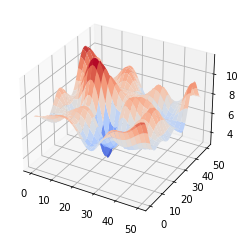

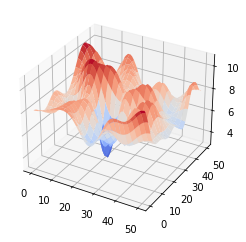

In [17]:
c = reconstructc(c_para[0][:8])
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = np.arange(Nx+1)
Y = np.arange(Nx+1)
X, Y = np.meshgrid(X, Y)
# Plot the surface.
surf = ax.plot_surface(X, Y, c[2].cpu().numpy(), cmap=cm.coolwarm)

c = reconstructc(predicted_coe[:8])
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = np.arange(Nx+1)
Y = np.arange(Nx+1)
X, Y = np.meshgrid(X, Y)
# Plot the surface.
surf = ax.plot_surface(X, Y, c[2].cpu().numpy(), cmap=cm.coolwarm)

In [18]:
checkpoint = {'model': model.module.state_dict()}
torch.save(checkpoint, './8fourier_25block_3channel_coe_notdecay.pth')
#torch.save(checkpoint, './10fourier_6block_3channel_coe.pth')

In [10]:
model = CNNResnet_VP(Block, 25)

model.load_state_dict(torch.load('./8fourier_25block_3channel_coe_notdecay.pth')['model'], strict=False);
model.cuda()
model= nn.DataParallel(model, device_ids=[0, 1]).to(device)

model.eval();

In [29]:
def neumann_data_bdry(time, Nx, hx, flag, T):
    sigma = 0.1
    x = torch.arange(0, 1 + hx, hx, device = device)
    
    if flag == 1:
        f = torch.exp(-(x-0.8)**2/sigma**2) - \
            torch.exp(-(x-0.2)**2/sigma**2)
    if flag == 2:
        f = torch.exp(-(x-0.4)**2/sigma**2) - \
            torch.exp(-(x-0.7)**2/sigma**2)
    if flag == 3:
        f = torch.exp(-(x-0.6)**2/sigma**2) - \
            torch.exp(-(x-0.3)**2/sigma**2)
    return f
bd = neumann_data_bdry(0.05, Nx, hx, 3, T)
#plt.plot(bd.cpu().numpy())
#plt.show()
bd.dtype

torch.float32

In [30]:
num_modes = 8
parameter = (torch.rand([1, num_modes, num_modes], device = device)-0.5)
parameter[:, 0, 0] += 8
c = reconstructc(parameter)
print(parameter)

tensor([[[ 8.0677, -0.4832, -0.1416, -0.1163,  0.2448, -0.3633, -0.3642,
          -0.1322],
         [-0.0555, -0.0440, -0.3007,  0.4783, -0.1169, -0.3864,  0.3049,
          -0.4056],
         [-0.0932,  0.4219,  0.2176,  0.2684, -0.1658,  0.1469,  0.4868,
          -0.3234],
         [ 0.3632, -0.1180, -0.4569, -0.0800, -0.4859,  0.4510, -0.1973,
          -0.3364],
         [ 0.1459,  0.4342, -0.1545,  0.2116,  0.0936,  0.0918,  0.0715,
          -0.2632],
         [-0.2252,  0.1455,  0.3567, -0.0365, -0.1168,  0.2472, -0.3052,
          -0.1143],
         [-0.4831, -0.0909, -0.2795,  0.0954,  0.2557,  0.1690, -0.1626,
          -0.0150],
         [-0.3116,  0.3463,  0.4929, -0.3764, -0.2634,  0.0900, -0.2696,
          -0.1965]]], device='cuda:0')


In [31]:

def subscript(t_flag, y_idx, x_idx, Nx, Ny):
    y_idx_amend = y_idx
    x_idx_amend = x_idx
    if y_idx <= -1:
        y_idx_amend = 1
    if y_idx >= Ny + 1:
        y_idx_amend = Ny -1
    if x_idx <= -1:
        x_idx_amend = Nx - 1
    if x_idx >= Nx + 1:
        x_idx_amend = 1
    if t_flag == -1:
        return y_idx_amend*(Nx + 1) + x_idx_amend
    if t_flag == 0:
        return y_idx_amend*(Nx + 1) + x_idx_amend + (Nx+1)*(Ny+1)   
    if t_flag == 1:
        return y_idx_amend*(Nx + 1) + x_idx_amend + (Nx+1)*(Ny+1)       
    if t_flag !=-1 and t_flag != 0 and t_flag != 1:
        raise Exception("wrong t_flag")
        
def iteration_matrix_bd(c, Nx, Ny, dt, hx, hy, T, force_flag):
    length = (Nx + 1)*(Ny + 1)

    iteration_matrix = torch.zeros([2*length, 2*length], device = device)
    for i in range(length):
        iteration_matrix[i, i + length] = 1.


    neumann_bdry_vector = torch.zeros(2*length, device = device)     
    bd_data = neumann_data_bdry(.05, Nx, hx, force_flag, T)

    for y_idx in range(Ny + 1):
        for x_idx in range(Nx + 1):
            subscpt_nt = subscript(1, y_idx, x_idx, Nx, Ny)
            vx = (c[y_idx, x_idx]*dt/hx)**2
            vy = (c[y_idx, x_idx]*dt/hy)**2
            iteration_matrix[subscpt_nt, subscript(0, y_idx, x_idx, Nx, Ny)] = \
            iteration_matrix[subscpt_nt, subscript(0, y_idx, x_idx, Nx, Ny)]+2*(1 - vx - vy)    
            iteration_matrix[subscpt_nt, subscript(-1, y_idx, x_idx, Nx, Ny)] = \
            iteration_matrix[subscpt_nt, subscript(-1, y_idx, x_idx, Nx, Ny)]-1
            iteration_matrix[subscpt_nt, subscript(0, y_idx, x_idx+1, Nx, Ny)] = \
            iteration_matrix[subscpt_nt, subscript(0, y_idx, x_idx+1, Nx, Ny)]+ vx
            iteration_matrix[subscpt_nt, subscript(0, y_idx, x_idx-1, Nx, Ny)] = \
            iteration_matrix[subscpt_nt, subscript(0, y_idx, x_idx-1, Nx, Ny)] + vx
            iteration_matrix[subscpt_nt, subscript(0, y_idx+1, x_idx, Nx, Ny)] = \
            iteration_matrix[subscpt_nt, subscript(0, y_idx+1, x_idx, Nx, Ny)] + vy
            iteration_matrix[subscpt_nt, subscript(0, y_idx-1, x_idx, Nx, Ny)] = \
            iteration_matrix[subscpt_nt, subscript(0, y_idx-1, x_idx, Nx, Ny)] + vy

            if y_idx == Ny:
                neumann_bdry_vector[subscpt_nt] = 2*dt**2*c[y_idx, x_idx]**2/hy*bd_data[x_idx]

    return iteration_matrix, neumann_bdry_vector

im, bdv = iteration_matrix_bd(c[0], Nx, Ny, dt, hx, hy,T,1)

In [32]:
shots_step = 20;
receiver_start_timer = 0;

def wave_solver(c, Nx, Ny, dt, hx, hy, T, shots_step, receiver_start_timer, Nsteps, force_flag):
    iteration_matrix, neumann_bdry_vector =\
    iteration_matrix_bd(c, Nx, Ny, dt, hx, hy,T,force_flag)

    u_vector = torch.zeros(2*(Nx + 1)*(Ny + 1), device = device)
    samples = torch.zeros([Nx + 1, int((Nsteps-receiver_start_timer)/shots_step+1)],device = device)
    #samples = torch.zeros([Nx + 1, Nsteps])
    #solution = torch.zeros([Ny + 1, Nx + 1, Nsteps], dtype = torch.float64)

    for tstep in range(1, Nsteps + 1):
        u_vector = torch.matmul(iteration_matrix, u_vector) + neumann_bdry_vector

    #     subscpt = subscript(1, 1, 0, Nx, Ny)
    #     samples[:,tstep-1] = u_vector[subscpt:subscpt + Nx + 1]

        #solution[:,:, tstep - 1] = u_vector[(Nx+1)*(Ny+1):].reshape(Ny + 1, Nx + 1)
        if tstep>=receiver_start_timer and (tstep - receiver_start_timer)% shots_step==0:
            subscpt = subscript(1, 0, 0, Nx, Ny)
            samples[:,int((tstep-receiver_start_timer)/shots_step)] = u_vector[subscpt:subscpt + Nx + 1]
    return samples

true_samples = torch.zeros([1, 3, Nx+1, Ny+1])


for force_flag in range(3):
    true_samples[0][force_flag] = wave_solver(c[0], Nx, Ny, dt, hx, hy, T, shots_step, receiver_start_timer, Nsteps,force_flag+1)

In [33]:
true_samples.detach().cpu().tolist();

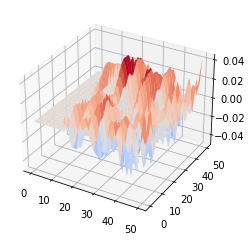

In [34]:
true_samples_cpu = true_samples.cpu().numpy()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = np.arange(51)
Y = np.arange(51)
X, Y = np.meshgrid(X, Y)


# Plot the surface.
surf = ax.plot_surface(X, Y, true_samples_cpu[0][0], cmap=cm.coolwarm)


In [35]:
true_samples.shape

torch.Size([1, 3, 51, 51])

In [36]:
#true_latents = model.encode(true_samples)

predicted_coe = model(true_samples.to(device))
predicted_coe - parameter

tensor([[[-0.0186,  0.0952,  0.1160, -0.1558,  0.0925,  0.1431, -0.0055,
          -0.1317],
         [ 0.0131,  0.0759,  0.0752, -0.0640,  0.0940,  0.1504, -0.1696,
           0.0801],
         [-0.0305, -0.0783,  0.0101, -0.0875,  0.1652, -0.0092, -0.0753,
           0.1183],
         [-0.0545, -0.0260,  0.0098,  0.1158,  0.0471,  0.1010,  0.1786,
           0.1281],
         [ 0.0374,  0.0406,  0.0154, -0.0010, -0.0767,  0.0681, -0.0074,
          -0.1318],
         [ 0.0365,  0.0427, -0.0530,  0.1142, -0.0557,  0.1108,  0.1541,
           0.0899],
         [ 0.0503,  0.0014, -0.0899,  0.1160, -0.0292, -0.0184,  0.1696,
          -0.0362],
         [-0.0309, -0.1035, -0.1144,  0.1940,  0.2059,  0.1114,  0.1884,
           0.1980]]], device='cuda:0', grad_fn=<SubBackward0>)

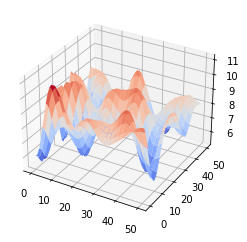

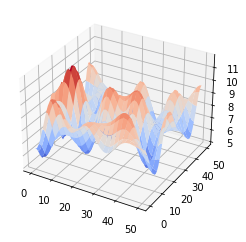

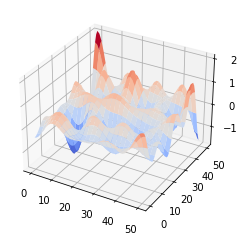

In [37]:
X = np.arange(Nx+1)
Y = np.arange(Ny+1)
X, Y = np.meshgrid(X, Y)
# Plot the surface.
predictedc = reconstructc(predicted_coe)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, predictedc[0].detach().cpu().numpy(), cmap=cm.coolwarm)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, c[0].cpu().numpy(), cmap=cm.coolwarm)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, predictedc[0].detach().cpu().numpy() - c[0].detach().cpu().numpy(), cmap=cm.coolwarm)




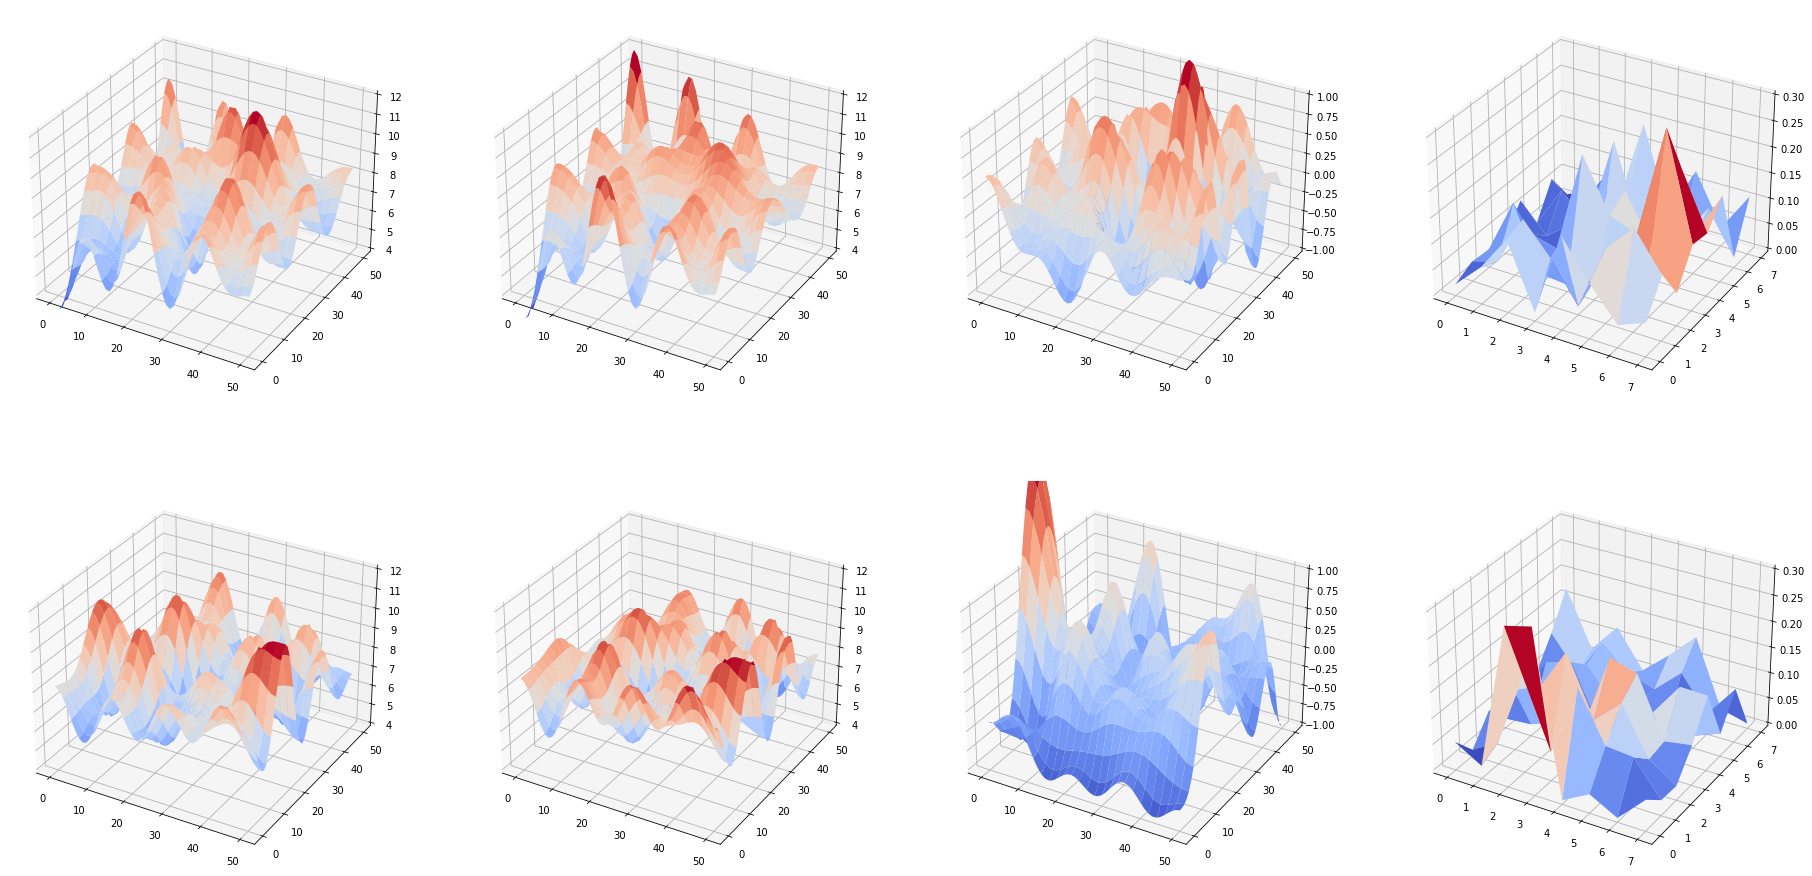

In [38]:
num = 2
fig, ax = plt.subplots(num, 4, subplot_kw={"projection": "3d"})

fig.set_figheight(num*8)
fig.set_figwidth(4*8)
X = np.arange(Nx+1)
Y = np.arange(Ny+1)
X, Y = np.meshgrid(X, Y)

x = np.arange(num_modes)
y = np.arange(num_modes)
x, y = np.meshgrid(x, y)

datair = iter(test_loader)
with torch.no_grad():
    for i in range(num):

        samples, c_para = datair.next()
        idx = torch.randint(0, batch_size,(1,))[0]
        predicted_coe = model(samples[0][idx:idx+1])
        true_coe = c_para[0][idx].detach().cpu().numpy()
        c2 = reconstructc(predicted_coe)
        c1 = reconstructc(c_para[0][idx:idx+1])
        c1 = c1[0].detach().cpu().numpy()
        c2 = c2[0].detach().cpu().numpy()
        error = c1-c2
        ax[i, 0].plot_surface(X, Y, c1, cmap=cm.coolwarm)
        ax[i, 1].plot_surface(X, Y, c2, cmap=cm.coolwarm)
        ax[i, 2].plot_surface(X, Y, error, cmap=cm.coolwarm)
        ax[i, 3].plot_surface(x, y, abs((predicted_coe[0].cpu().numpy() - true_coe)), cmap=cm.coolwarm)
        ax[i, 0].set_zlim([4, 12])
        ax[i, 1].set_zlim([4, 12])
        ax[i, 2].set_zlim([-1, 1])
        ax[i, 3].set_zlim([0, .3])

plt.show()

In [39]:
from matplotlib.colors import LinearSegmentedColormap
cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]
parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

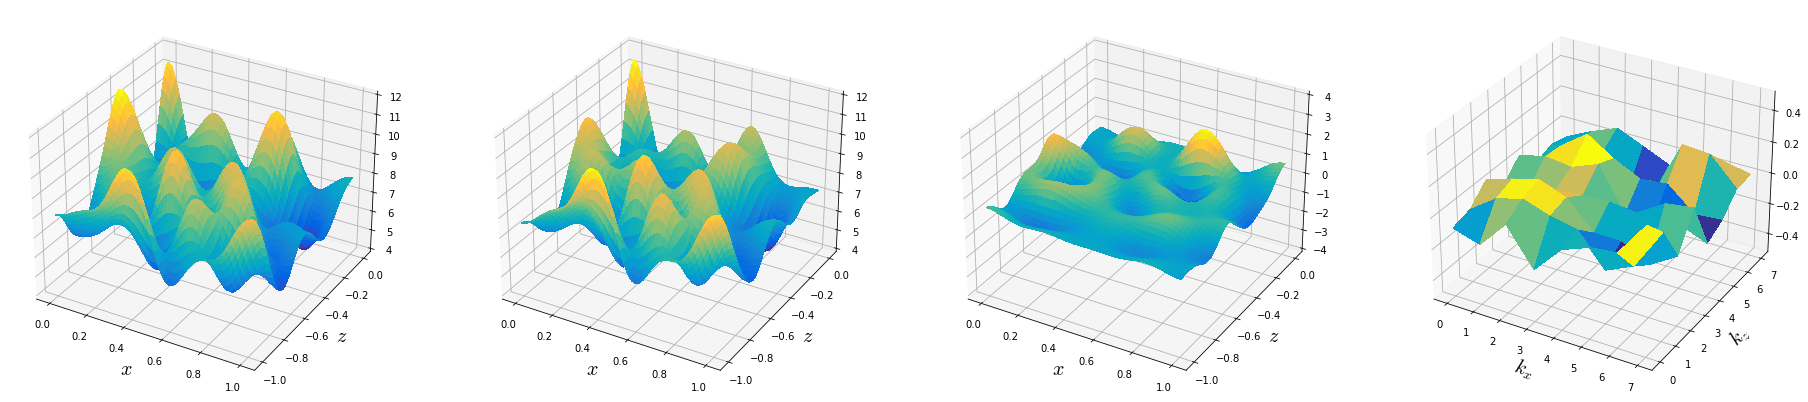

In [40]:
num = 1
fig, ax = plt.subplots(num, 4, subplot_kw={"projection": "3d"})

fig.set_figheight(num*8)
fig.set_figwidth(4*8)
X = np.arange(Nx+1)/Nx
Y = np.arange(-Ny,1)/Nx
X, Y = np.meshgrid(X, Y)

x = np.arange(num_modes)
y = np.arange(num_modes)
x, y = np.meshgrid(x, y)

datair = iter(test_loader)
with torch.no_grad():
    for i in range(num):

        samples, c_para = datair.next()
        idx = torch.randint(0, batch_size,(1,))[0]
        predicted_coe = model(samples[0][idx:idx+1])
        true_coe = c_para[0][idx].detach().cpu().numpy()
        c2 = reconstructc(predicted_coe)
        c1 = reconstructc(c_para[0][idx:idx+1])
        c1 = c1[0].detach().cpu().numpy()
        c2 = c2[0].detach().cpu().numpy()
        error = c1-c2
        ax[0].plot_surface(X, Y, c1, cmap=parula_map, rstride=1, cstride=1, linewidth=0,
                       antialiased=False)
        ax[1].plot_surface(X, Y, c2, cmap=parula_map, rstride=1, cstride=1, linewidth=0,
                       antialiased=False)
        ax[2].plot_surface(X, Y, error, cmap=parula_map, rstride=1, cstride=1, linewidth=0,
                       antialiased=False)
        ax[3].plot_surface(x, y, (predicted_coe[0].cpu().numpy() - true_coe), cmap=parula_map, rstride=1, cstride=1, linewidth=0,
                       antialiased=False)
        ax[0].set_zlim([4, 12])
        ax[1].set_zlim([4, 12])
        ax[2].set_zlim([-4, 4])
        ax[3].set_zlim([-0.5, 0.5])
        
        ax[0].set_xlabel('$x$', fontsize=20,math_fontfamily='cm')
        ax[0].set_ylabel('$z$', fontsize=20,math_fontfamily='cm')
        ax[1].set_xlabel('$x$', fontsize=20,math_fontfamily='cm')
        ax[1].set_ylabel('$z$', fontsize=20,math_fontfamily='cm')
        #ax[1].set_zlabel('$m$', fontsize=15)
        
        ax[2].set_xlabel('$x$', fontsize=20,math_fontfamily='cm')
        ax[2].set_ylabel('$z$', fontsize=20,math_fontfamily='cm')
        
        ax[3].set_xlabel('$k_x$', fontsize=20,math_fontfamily='cm')
        ax[3].set_ylabel('$k_z$', fontsize=20,math_fontfamily='cm')
plt.show()

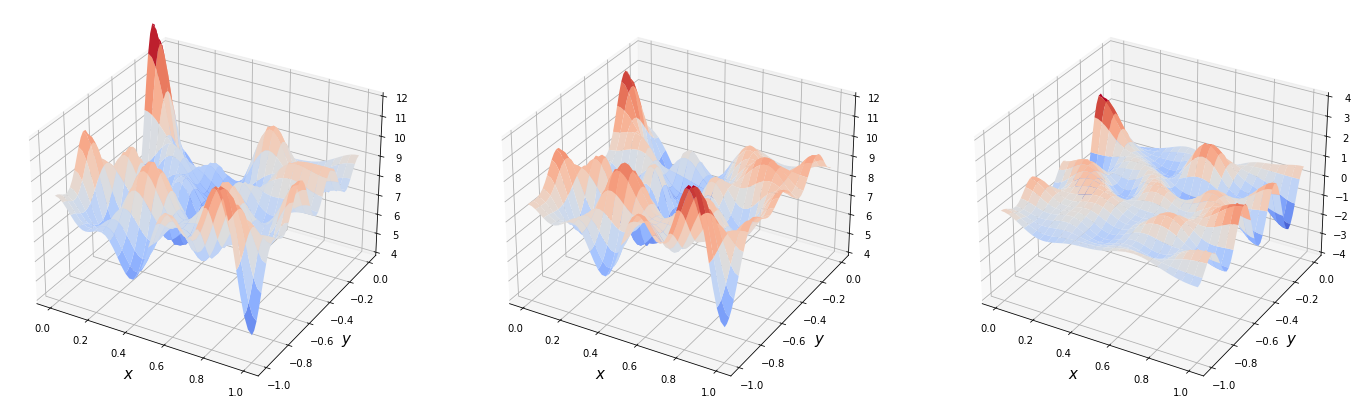

In [41]:
num = 1
fig, ax = plt.subplots(num, 3, subplot_kw={"projection": "3d"})

fig.set_figheight(num*8)
fig.set_figwidth(3*8)
X = np.arange(Nx+1)/Nx
Y = np.arange(-Ny,1)/Nx
X, Y = np.meshgrid(X, Y)

x = np.arange(num_modes)
y = np.arange(num_modes)
x, y = np.meshgrid(x, y)

datair = iter(test_loader)
with torch.no_grad():
    for i in range(num):

        samples, c_para = datair.next()
        idx = torch.randint(0, batch_size,(1,))[0]
        predicted_coe = model(samples[0][idx:idx+1])
        true_coe = c_para[0][idx].detach().cpu().numpy()
        c2 = reconstructc(predicted_coe)
        c1 = reconstructc(c_para[0][idx:idx+1])
        c1 = c1[0].detach().cpu().numpy()
        c2 = c2[0].detach().cpu().numpy()
        error = c1-c2
        ax[0].plot_surface(X, Y, c1, cmap=cm.coolwarm)
        ax[1].plot_surface(X, Y, c2, cmap=cm.coolwarm)
        ax[2].plot_surface(X, Y, error, cmap=cm.coolwarm)
        #ax[3].plot_surface(x, y, (predicted_coe[0].cpu().numpy() - true_coe), cmap=cm.coolwarm)
        ax[0].set_zlim([4, 12])
        ax[1].set_zlim([4, 12])
        ax[2].set_zlim([-4, 4])
        #ax[3].set_zlim([-0.5, 0.5])
        
        ax[0].set_xlabel('$x$', fontsize=15)
        ax[0].set_ylabel('$y$', fontsize=15)
        #ax[0].set_zlabel('$m$', fontsize=15)
        ax[1].set_xlabel('$x$', fontsize=15)
        ax[1].set_ylabel('$y$', fontsize=15)
        #ax[1].set_zlabel('$m$', fontsize=15)
        
        ax[2].set_xlabel('$x$', fontsize=15)
        ax[2].set_ylabel('$y$', fontsize=15)
        
                
#         ax[3].set_xlabel('$n_x$', fontsize=15)
#         ax[3].set_ylabel('$n_y$', fontsize=15)
#         ax[3].set_zlabel('$error \ of\  a_{nx, ny}$', fontsize=15)

plt.show()